In [6]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [7]:
MINIMUM_PEPTIDE_SCORE = 30
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.

In [8]:
my_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/F360157.csv', sep=',', index_col=False, skiprows=61)
my_results_df = my_results_df[my_results_df.pep_score >= MINIMUM_PEPTIDE_SCORE]


In [9]:
mq_results_df = pd.read_csv('/Users/darylwilding-mcbride/Downloads/F359466.csv', sep=',', index_col=False, skiprows=61)
mq_results_df = mq_results_df[mq_results_df.pep_score >= MINIMUM_PEPTIDE_SCORE]

In [10]:
len(my_results_df), len(mq_results_df)

(869, 171)

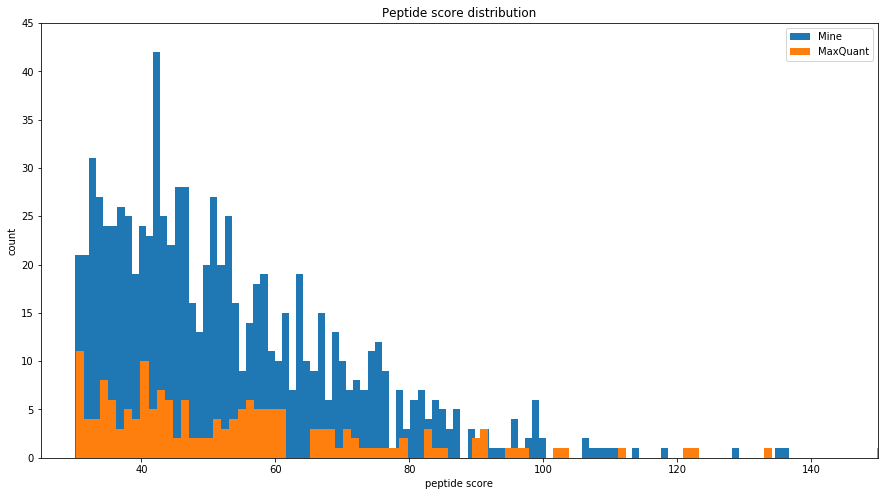

In [11]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score distribution')

h_bins = 100
hist, bins, _ = plt.hist(my_results_df.pep_score, bins=h_bins, label='Mine')
hist, bins, _ = plt.hist(mq_results_df.pep_score, bins=h_bins, label='MaxQuant')
plt.legend(loc='best')
plt.xlabel('peptide score')
plt.ylabel('count')

plt.xlim([25,150])
plt.ylim([0,45])

plt.show()

In [12]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

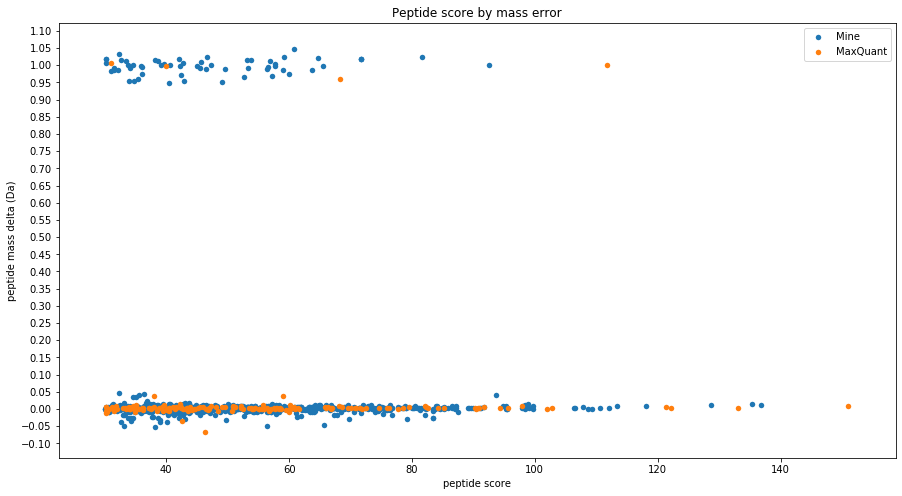

In [13]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score by mass error')

ax.scatter(my_results_df.pep_score, my_results_df.pep_delta, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")
ax.scatter(mq_results_df.pep_score, mq_results_df.pep_delta, marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="MaxQuant")

plt.legend(loc='best')
plt.xlabel('peptide score')
plt.ylabel('peptide mass delta (Da)')
plt.yticks(np.arange(-0.1,1.1,0.05))

plt.show()

In [14]:
# number of peptide matches
my_peptides = list(my_results_df.pep_seq.unique())
mq_peptides = list(mq_results_df.pep_seq.unique())

In [15]:
my_results_df.pep_seq.unique()[:10]

array(['TTPSVVAFTADGER', 'SQVFSTAADGQTQVEIK', 'ILDSVGIEADDDR',
       'ILDSVGIEADDDRLNK', 'VDSAATSGYEIGNPPDYR', 'TSRPENAIIYNNNEDFQVGQAK',
       'HIFSEDTSDFSGMSETK', 'FSMPSLK', 'AEGPDVAVDLPK', 'GEGPDVDVTLPK'],
      dtype=object)

In [16]:
my_results_df['retention_time'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[9]))
my_results_df['feature_id'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[7]))
my_results_df['intensity'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[5]))

In [17]:
p_df = my_results_df[my_results_df.pep_seq == 'TSRPENAIIYNNNEDFQVGQAK'][['pep_exp_mz','retention_time','pep_delta','pep_exp_z','feature_id','intensity']]
p_df

,pep_exp_mz,retention_time,pep_delta,pep_exp_z,feature_id,intensity
65,836.7370,3060.17,-0.0148,3,1096,127122.0
66,836.7389,3060.43,-0.0091,3,767,170160.0
67,836.7405,3060.34,-0.0043,3,727,178357.0
69,627.8109,3059.95,0.0105,4,306,350992.0
70,627.8111,3059.54,0.0112,4,234,442234.0
71,836.7458,3065.04,0.0117,3,189,529778.0
72,836.7459,3059.89,0.0117,3,252,425263.0
73,627.8112,3059.22,0.0118,4,309,350068.0
74,836.7459,3059.78,0.0118,3,25,2572152.0
75,836.7459,3059.92,0.0118,3,103,913203.0


In [18]:
ms1_dedup_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/rt-3000-3060-nddms1.pkl')

In [19]:
list(p_df.feature_id)

[1096, 767, 727, 306, 234, 189, 252, 309, 25, 103, 219, 28, 220]

In [20]:
df = ms1_dedup_features_df[ms1_dedup_features_df.feature_id.isin(list(p_df.feature_id))]
df[['envelope','monoisotopic_mz','intensity']]

,envelope,monoisotopic_mz,intensity
24,"((707.3850, 613378.00), (707.8844, 468271.00),...",707.384998,1.369528e+06
27,"((616.8235, 648341.00), (617.3235, 427525.00),...",616.824082,1.254981e+06
102,"((652.3320, 209799.00), (652.8333, 148853.00),...",652.332586,4.324710e+05
188,"((537.2699, 142910.00), (537.7835, 75450.00), ...",537.278339,2.681130e+05
218,"[(754.4097777944762, 99715.96952433884), (754....",754.405545,2.385280e+05
219,"((670.8563, 64199.00), (671.3572, 46789.00), (...",670.857965,2.374920e+05
233,"((498.2692, 123968.00), (498.6072, 53861.00), ...",498.273264,2.298640e+05
251,"((446.7222, 117558.00), (447.2268, 72763.00), ...",446.722175,2.186940e+05
305,"((554.5992, 58464.00), (554.9248, 54993.00), (...",554.595271,1.910810e+05
308,"((661.3130, 87805.00), (661.8174, 63212.00), (...",661.310295,1.897280e+05


In [21]:
df.mono_adjusted

24      False
27      False
102     False
188     False
218      True
219     False
233     False
251     False
305     False
308     False
726     False
766     False
1095    False
Name: mono_adjusted, dtype: bool

In [22]:
envelope_intensity = 0
for i in range(len(df.iloc[0].envelope)):
    envelope_intensity += df.iloc[0].envelope[i][1]
envelope_intensity

1369528.0

In [23]:
mz_ppm_tolerance = df.iloc[0].monoisotopic_mz * (5 * 10**-4) / 100
mz_ppm_tolerance

0.0035369249907506294

In [24]:
mq_results_df.iloc[0].pep_scan_title

'RawFile: HeLa_20KInt_2KIT_Slot1-46_01_1179 Index: 32703 Charge: 2 FeatureIntensity: 509830 RtApex: 3027.22'

Question: for the features detected in common, what did each algorithm identify it as?
* for each feature detected by PDA (PASEF-driven approach) and identified, find a matching feature in MQ (RT, PEPMASS, charge)
* get the Index from MQ, and the precursor ID from PDA
* what peptide was each identified as? how did the scores differ?

In [25]:
my_results_df.columns

Index(['prot_hit_num', 'prot_family_member', 'prot_acc', 'prot_desc',
       'prot_score', 'prot_mass', 'prot_matches', 'prot_matches_sig',
       'prot_sequences', 'prot_sequences_sig', 'pep_query', 'pep_rank',
       'pep_isbold', 'pep_isunique', 'pep_exp_mz', 'pep_exp_mr', 'pep_exp_z',
       'pep_calc_mr', 'pep_delta', 'pep_miss', 'pep_score', 'pep_expect',
       'pep_res_before', 'pep_seq', 'pep_res_after', 'pep_var_mod',
       'pep_var_mod_pos', 'pep_summed_mod_pos', 'pep_scan_title',
       'retention_time', 'feature_id', 'intensity'],
      dtype='object')

In [26]:
mq_results_df['retention_time'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[9]))
mq_results_df['Index'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[3]))
mq_results_df['intensity'] = mq_results_df.pep_scan_title.str.split(" ").apply(lambda x: float(x[7]))

In [27]:
mq_results_df.iloc[0].pep_scan_title

'RawFile: HeLa_20KInt_2KIT_Slot1-46_01_1179 Index: 32703 Charge: 2 FeatureIntensity: 509830 RtApex: 3027.22'

In [28]:
mz_ppm = 10
rt_tolerance = 2

In [29]:
match_count = 0
match_l = []
for idx,row in my_results_df.iterrows():
    # m/z criteria
    mz = row.pep_exp_mz
    mz_ppm_tolerance = mz * (10 * 10**-4) / 100
    mz_lower = mz - mz_ppm_tolerance
    mz_upper = mz + mz_ppm_tolerance
    # RT criteria
    rt = row.retention_time
    rt_lower = rt - rt_tolerance
    rt_upper = rt + rt_tolerance
    # charge criteria
    charge = row.pep_exp_z
    # find match in the MQ features
    mq_matches = mq_results_df[(mq_results_df.pep_exp_mz >= mz_lower) & (mq_results_df.pep_exp_mz <= mz_upper) & (mq_results_df.retention_time >= rt_lower) & (mq_results_df.retention_time <= rt_upper) & (mq_results_df.pep_exp_z == charge)]
    if len(mq_matches) >= 1:
        match_count += 1
        highest_score_mq_match = mq_matches.loc[mq_matches.pep_score.idxmax()]
        feature_id = row.feature_id
        pda_pep_score = row.pep_score
        mq_index = highest_score_mq_match.Index
        mq_pep_score = highest_score_mq_match.pep_score
        # is the identified peptide the same one or different?
        same_peptide = (highest_score_mq_match.pep_seq == row.pep_seq)
        match_l.append((feature_id, pda_pep_score, mq_index, mq_pep_score, same_peptide))
print("{} PDA identified features matched MQ features".format(match_count))

266 PDA identified features matched MQ features


In [30]:
matches_df = pd.DataFrame(match_l, columns=['pda_feature_id','pda_pep_score','mq_index','mq_pep_score','same_peptide'])

In [31]:
matches_df.head()

,pda_feature_id,pda_pep_score,mq_index,mq_pep_score,same_peptide
0,1486,74.29,48273,79.6,True
1,447,61.87,48273,79.6,True
2,3823,62.38,48273,79.6,True
3,146,67.78,48273,79.6,True
4,101,89.15,48273,79.6,True


In [32]:
pda_only = my_results_df[~my_results_df.feature_id.isin(matches_df.pda_feature_id)]

In [33]:
mq_only = mq_results_df[~mq_results_df.Index.isin(matches_df.mq_index)]

In [34]:
intersection = len(set(mq_peptides).intersection(my_peptides))

In [35]:
print("my results had {} peptides, MQ had {} peptides, and there were {} in common".format(len(my_peptides), len(mq_peptides), intersection))

my results had 386 peptides, MQ had 149 peptides, and there were 133 in common


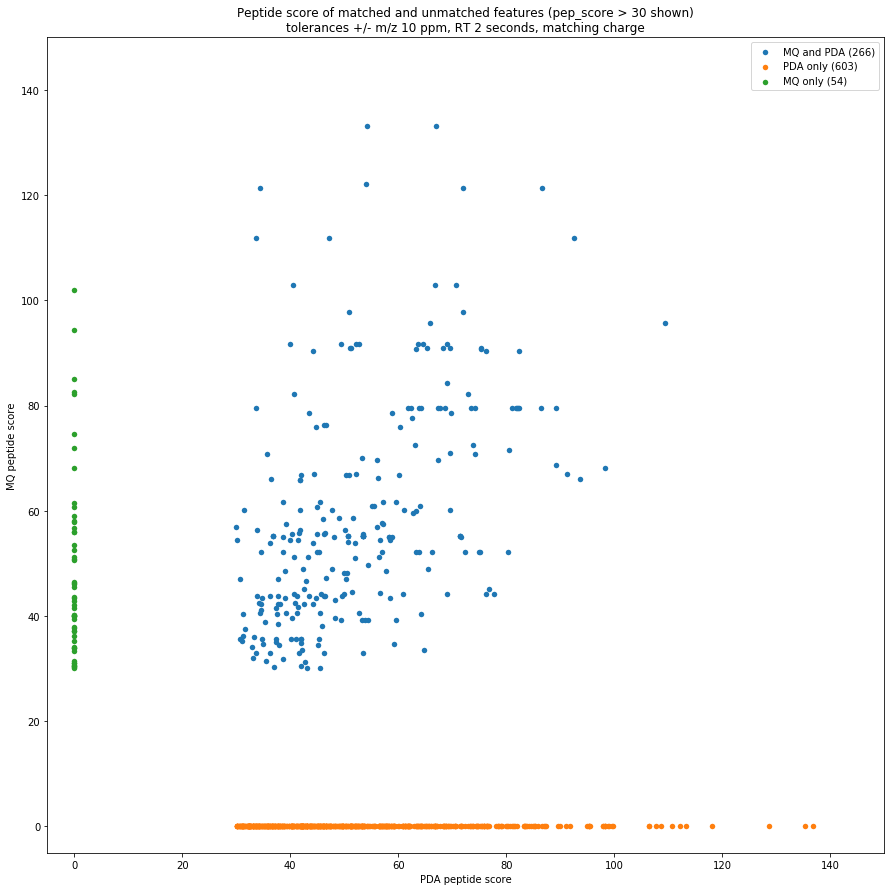

In [36]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score of matched and unmatched features (pep_score > {} shown)\ntolerances +/- m/z {} ppm, RT {} seconds, matching charge'.format(MINIMUM_PEPTIDE_SCORE, mz_ppm, rt_tolerance))

ax.scatter(matches_df.pda_pep_score, matches_df.mq_pep_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="MQ and PDA ({})".format(len(matches_df)))
ax.scatter(pda_only.pep_score, np.full((len(pda_only)), 0), marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="PDA only ({})".format(len(pda_only)))
ax.scatter(np.full((len(mq_only)), 0), mq_only.pep_score, marker='o', color=tableau20_mpl[4], lw=0, s=30, alpha=1.0, label="MQ only ({})".format(len(mq_only)))

plt.legend(loc='best')
plt.xlabel('PDA peptide score')
plt.ylabel('MQ peptide score')

plt.xlim([-5,150])
plt.ylim([-5,150])

plt.show()

In [37]:
my_results_df.columns

Index(['prot_hit_num', 'prot_family_member', 'prot_acc', 'prot_desc',
       'prot_score', 'prot_mass', 'prot_matches', 'prot_matches_sig',
       'prot_sequences', 'prot_sequences_sig', 'pep_query', 'pep_rank',
       'pep_isbold', 'pep_isunique', 'pep_exp_mz', 'pep_exp_mr', 'pep_exp_z',
       'pep_calc_mr', 'pep_delta', 'pep_miss', 'pep_score', 'pep_expect',
       'pep_res_before', 'pep_seq', 'pep_res_after', 'pep_var_mod',
       'pep_var_mod_pos', 'pep_summed_mod_pos', 'pep_scan_title',
       'retention_time', 'feature_id', 'intensity'],
      dtype='object')

In [38]:
# for each unique peptide sequence / charge / modification, what was PDA's best score and what was MQ's best score?


In [39]:
len(mq_peptides)

149

In [40]:
mq_set = set(mq_peptides)
my_set = set(my_peptides)

In [41]:
combined_set = mq_set.union(my_set)

In [42]:
len(combined_set)

402

In [43]:
best_identifications_l = []
for peptide in combined_set:
    my_ids = my_results_df[my_results_df.pep_seq == peptide][['pep_exp_z','pep_score']]
    mq_ids = mq_results_df[mq_results_df.pep_seq == peptide][['pep_exp_z','pep_score']]
    same_peptide_different_charge = False
    if (len(my_ids) > 0) and (len(mq_ids) > 0):
        charge_match = pd.merge(my_ids, mq_ids, how='inner', left_on=['pep_exp_z'], right_on = ['pep_exp_z'])
        if len(charge_match) > 0:
            best_my_score = charge_match.pep_score_x.max()
            best_mq_score = charge_match.pep_score_y.max()
        else:  # didn't match on charge but record score anyway for debugging
            best_my_score = my_ids.pep_score.max()
            best_mq_score = mq_ids.pep_score.max()
            same_peptide_different_charge = True
    elif (len(my_ids) > 0) and (len(mq_ids) == 0):
        best_my_score = my_ids.pep_score.max()
        best_mq_score = None
    elif (len(my_ids) == 0) and (len(mq_ids) > 0):
        best_my_score = None
        best_mq_score = mq_ids.pep_score.max()
    else:
        print("this shouldn't happen")
    best_identifications_l.append((peptide,best_my_score,best_mq_score,same_peptide_different_charge))

best_identifications_df = pd.DataFrame(best_identifications_l, columns=['peptide','pda_score','mq_score','different_charge'])

In [44]:
best_identifications_df.head()

,peptide,pda_score,mq_score,different_charge
0,LLVLDPAQR,44.77,43.38,False
1,IPYQSPVSSSESAPGTIMNGHGGGR,40.36,NaN,False
2,ALESELQQLR,37.71,46.97,False
3,QPVTVADYISR,43.11,NaN,False
4,IYWSDLSQR,46.78,NaN,False


In [45]:
match_both_df = best_identifications_df[pd.notna(best_identifications_df.pda_score) & pd.notna(best_identifications_df.mq_score)]
match_pda_only_df = best_identifications_df[pd.notna(best_identifications_df.pda_score) & pd.isna(best_identifications_df.mq_score)]
match_mq_only_df = best_identifications_df[pd.isna(best_identifications_df.pda_score) & pd.notna(best_identifications_df.mq_score)]

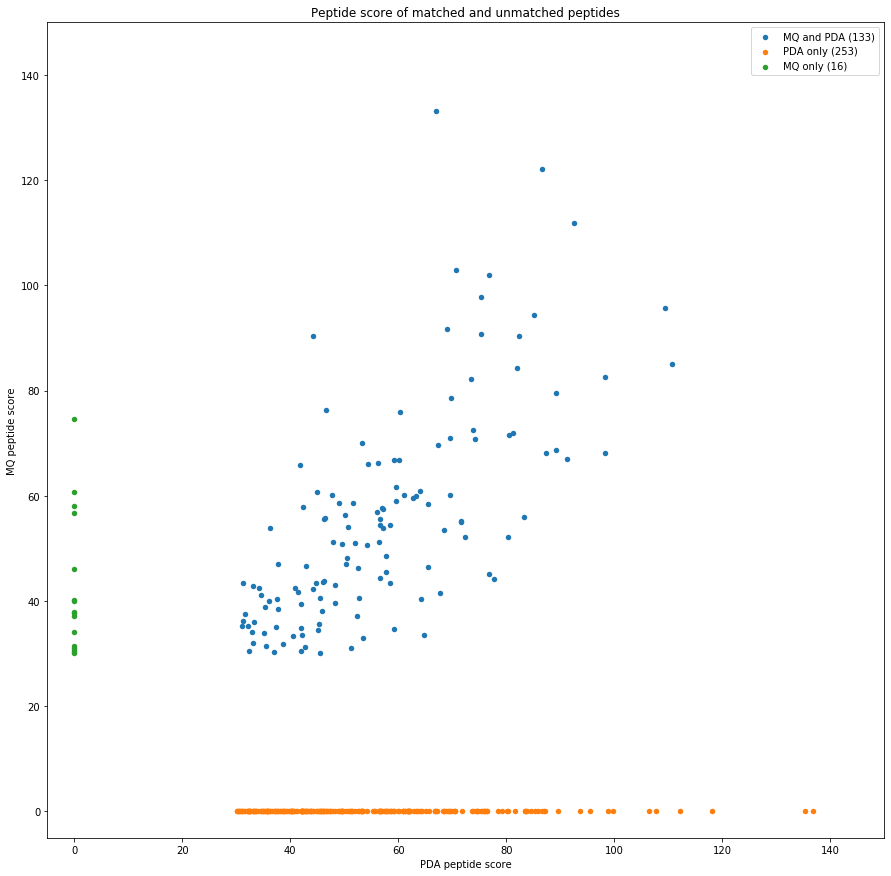

In [46]:
f, ax = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score of matched and unmatched peptides')

ax.scatter(match_both_df.pda_score, match_both_df.mq_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="MQ and PDA ({})".format(len(match_both_df)))
ax.scatter(match_pda_only_df.pda_score, np.full((len(match_pda_only_df)), 0), marker='o', color=tableau20_mpl[2], lw=0, s=30, alpha=1.0, label="PDA only ({})".format(len(match_pda_only_df)))
ax.scatter(np.full((len(match_mq_only_df)), 0), match_mq_only_df.mq_score, marker='o', color=tableau20_mpl[4], lw=0, s=30, alpha=1.0, label="MQ only ({})".format(len(match_mq_only_df)))

plt.legend(loc='best')
plt.xlabel('PDA peptide score')
plt.ylabel('MQ peptide score')

plt.xlim([-5,150])
plt.ylim([-5,150])

plt.show()

In [47]:
count_list = []
count_list.append(('PASEF', len(my_peptides)))
count_list.append(('MaxQuant', len(mq_peptides)))
count_list.append(('Common', intersection))

In [48]:
count_df = pd.DataFrame(count_list, columns=['method','peptide_count'])

In [49]:
count_df

,method,peptide_count
0,PASEF,386
1,MaxQuant,149
2,Common,133


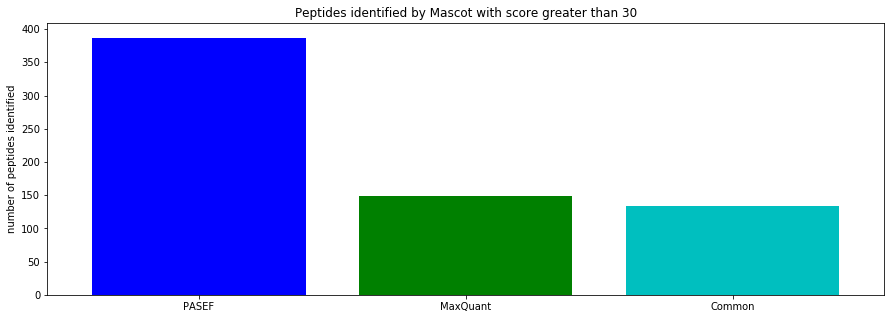

In [50]:
fig, ax1 = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(15)
plt.bar(count_df.iloc[0].method, count_df.iloc[0].peptide_count, align='center', width=0.8, color='b')
plt.bar(count_df.iloc[1].method, count_df.iloc[1].peptide_count, align='center', width=0.8, color='g')
plt.bar(count_df.iloc[2].method, count_df.iloc[2].peptide_count, align='center', width=0.8, color='c')
plt.ylabel('number of peptides identified')
plt.title('Peptides identified by Mascot with score greater than {}'.format(MINIMUM_PEPTIDE_SCORE))
plt.margins(0.06)
plt.show()

In [51]:
my_results_df.columns

Index(['prot_hit_num', 'prot_family_member', 'prot_acc', 'prot_desc',
       'prot_score', 'prot_mass', 'prot_matches', 'prot_matches_sig',
       'prot_sequences', 'prot_sequences_sig', 'pep_query', 'pep_rank',
       'pep_isbold', 'pep_isunique', 'pep_exp_mz', 'pep_exp_mr', 'pep_exp_z',
       'pep_calc_mr', 'pep_delta', 'pep_miss', 'pep_score', 'pep_expect',
       'pep_res_before', 'pep_seq', 'pep_res_after', 'pep_var_mod',
       'pep_var_mod_pos', 'pep_summed_mod_pos', 'pep_scan_title',
       'retention_time', 'feature_id', 'intensity'],
      dtype='object')

In [52]:
my_results_df['feature_id'] = my_results_df.pep_scan_title.str.split(" ").apply(lambda x: int(x[7]))
ms1_features_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/ms1_deduped_df.pkl')
my_results_df = pd.merge(my_results_df, ms1_features_df, how='left', left_on=['feature_id'], right_on=['feature_id'])

In [53]:
denom = (my_results_df.pep_calc_mr + (my_results_df.charge * PROTON_MASS)) / PROTON_MASS
pep_ppm = (my_results_df.pep_delta / denom) * 1e6
my_results_df['pep_ppm'] = round(pep_ppm).astype(int)

In [54]:
my_results_df = my_results_df[(my_results_df.pep_ppm > -100) & (my_results_df.pep_ppm < 100)]

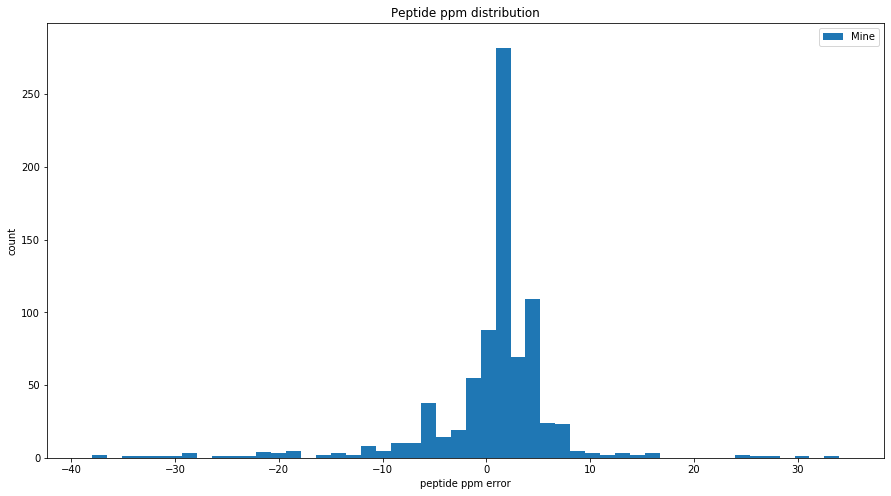

In [55]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide ppm distribution')

bins = 50
hist, bins, _ = plt.hist(my_results_df.pep_ppm, bins=bins, label='Mine')
plt.legend(loc='best')
plt.xlabel('peptide ppm error')
plt.ylabel('count')

plt.show()

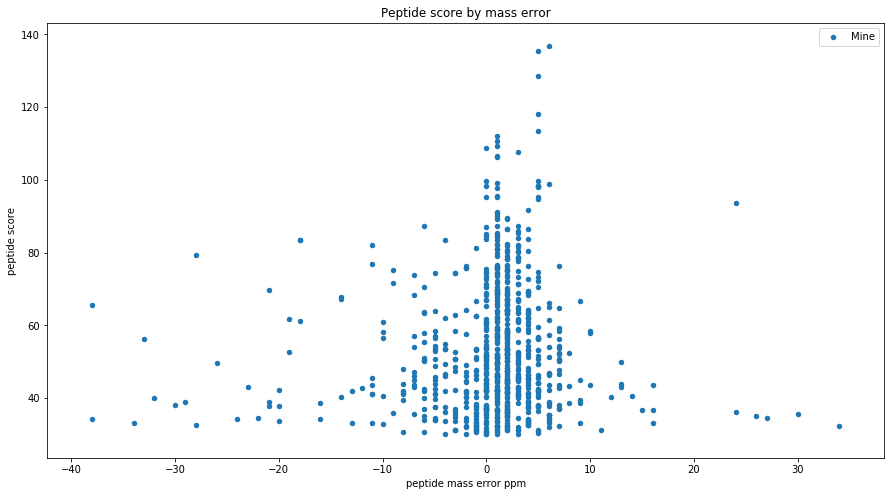

In [56]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide score by mass error')

ax.scatter(my_results_df.pep_ppm, my_results_df.pep_score, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('peptide score')

plt.show()

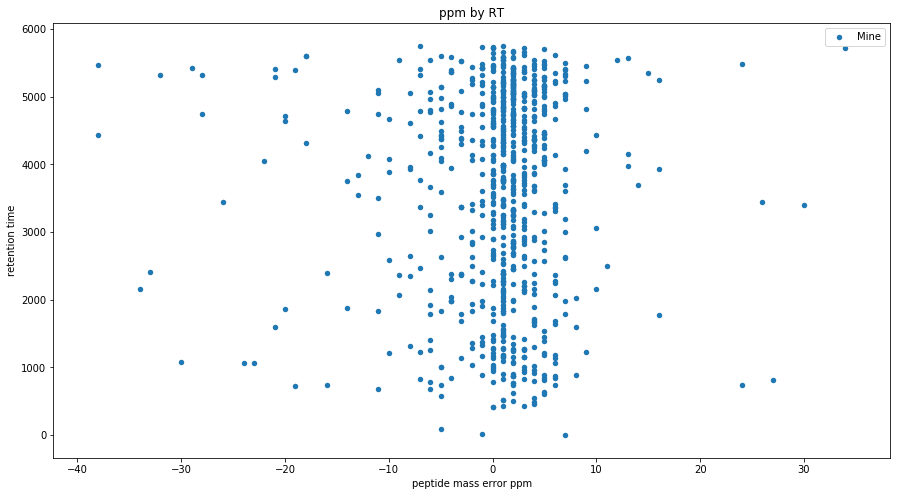

In [57]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by RT')

ax.scatter(my_results_df.pep_ppm, my_results_df.rt_apex, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('retention time')

plt.show()

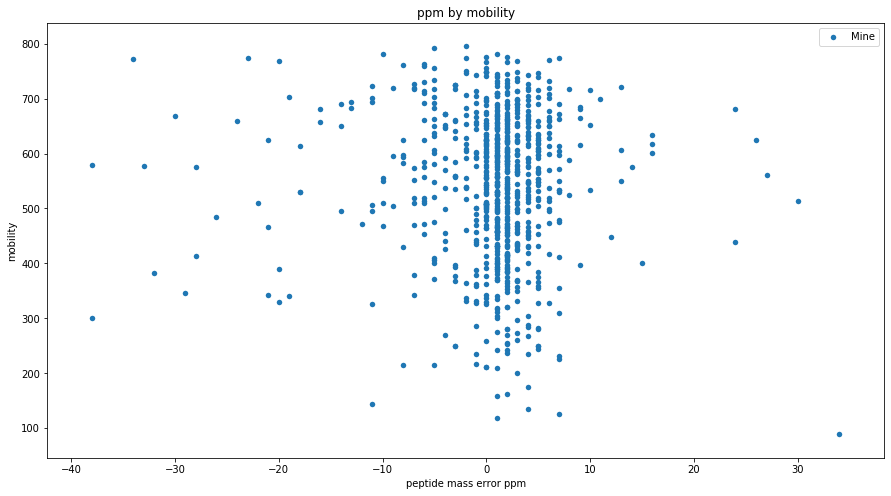

In [58]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('ppm by mobility')

ax.scatter(my_results_df.pep_ppm, my_results_df.scan_apex, marker='o', color=tableau20_mpl[0], lw=0, s=30, alpha=1.0, label="Mine")

plt.legend(loc='best')
plt.xlabel('peptide mass error ppm')
plt.ylabel('mobility')

plt.show()